In [ ]:
# Automated Metadata Generation System - Demo
'''
This notebook demonstrates the complete pipeline for automated metadata generation from documents using AI and NLP techniques.

## Features:
- Text extraction from PDF, DOCX, TXT files
- Named Entity Recognition (NER)
- Document summarization and classification
- Keyword extraction
- Dublin Core metadata generation
'''

In [2]:
# Install required packages
!pip install pymupdf pdf2image python-docx pillow pytesseract spacy transformers keybert scikit-learn pandas numpy matplotlib seaborn
!python -m spacy download en_core_web_sm


Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 8.8 MB/s eta 0:00:02
     ---------- ----------------------------- 3.4/12.8 MB 16.6 MB/s eta 0:00:01
     ----------------------- ---------------- 7.6/12.8 MB 15.3 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 15.1 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 13.9 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 13.9 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 11.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Import our modules
from app.extractors.pdf_extractor import extract_text_from_pdf, extract_metadata_from_pdf
from app.extractors.docx_extractor import extract_text_from_docx, extract_metadata_from_docx
from app.nlp.semantic_analysis import (
    perform_ner, generate_summary, classify_text, 
    extract_keywords, analyze_sentiment, identify_key_sections
)
from app.metadata.dublin_core_mapper import map_to_dublin_core

print("✅ All libraries imported successfully!")


INFO:app.nlp.semantic_analysis:SpaCy model loaded successfully
Device set to use cpu
INFO:app.nlp.semantic_analysis:Summarization model loaded successfully
Device set to use cpu
INFO:app.nlp.semantic_analysis:Classification model loaded successfully
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:app.nlp.semantic_analysis:KeyBERT model loaded successfully
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initial

✅ All libraries imported successfully!


In [4]:
def process_document(file_path):
    """Complete document processing pipeline."""
    
    # Determine file type
    file_ext = os.path.splitext(file_path)[1].lower()
    
    # Extract text and metadata
    if file_ext == '.pdf':
        text = extract_text_from_pdf(file_path)
        file_metadata = extract_metadata_from_pdf(file_path)
    elif file_ext == '.docx':
        text = extract_text_from_docx(file_path)
        file_metadata = extract_metadata_from_docx(file_path)
    elif file_ext == '.txt':
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        file_metadata = {}
    else:
        raise ValueError(f"Unsupported file type: {file_ext}")
    
    if not text:
        raise ValueError("Could not extract text from document")
    
    print(f"📄 Extracted {len(text)} characters from {os.path.basename(file_path)}")
    
    # Perform semantic analysis
    entities = perform_ner(text)
    summary = generate_summary(text)
    categories = classify_text(text)
    keywords = extract_keywords(text)
    sentiment = analyze_sentiment(text)
    key_sections = identify_key_sections(text)
    
    # Prepare extracted metadata
    extracted_metadata = {
        'entities': entities,
        'summary': summary,
        'categories': categories,
        'keywords': keywords,
        'sentiment': sentiment,
        'key_sections': key_sections,
        'text_length': len(text),
        'word_count': len(text.split())
    }
    
    # Add filename to file metadata
    file_metadata['filename'] = os.path.basename(file_path)
    
    # Map to Dublin Core
    dc_metadata = map_to_dublin_core(extracted_metadata, file_metadata)
    
    return {
        'text': text,
        'extracted_metadata': extracted_metadata,
        'file_metadata': file_metadata,
        'dublin_core_metadata': dc_metadata
    }

print("✅ Document processing pipeline defined!")


✅ Document processing pipeline defined!


In [5]:
def visualize_entities(entities):
    """Visualize named entities."""
    if not entities:
        print("No entities found")
        return
    
    # Count entities by type
    entity_counts = {k: len(v) for k, v in entities.items() if v}
    
    if entity_counts:
        plt.figure(figsize=(10, 6))
        bars = plt.bar(entity_counts.keys(), entity_counts.values(), color='skyblue')
        plt.title('Named Entities by Type', fontsize=16, fontweight='bold')
        plt.xlabel('Entity Type', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

def visualize_keywords(keywords):
    """Visualize top keywords."""
    if not keywords:
        print("No keywords found")
        return
    
    # Extract keyword strings and scores
    if isinstance(keywords[0], tuple):
        kw_data = [(kw[0], kw[1]) for kw in keywords[:10]]
        words, scores = zip(*kw_data)
    else:
        words = keywords[:10]
        scores = [1] * len(words)
    
    plt.figure(figsize=(12, 6))
    bars = plt.barh(range(len(words)), scores, color='lightcoral')
    plt.yticks(range(len(words)), words)
    plt.title('Top Keywords by Relevance', fontsize=16, fontweight='bold')
    plt.xlabel('Relevance Score', fontsize=12)
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2.,
                f'{width:.3f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

def visualize_categories(categories):
    """Visualize document categories."""
    if not categories:
        print("No categories found")
        return
    
    plt.figure(figsize=(8, 8))
    colors = plt.cm.Set3(range(len(categories)))
    plt.pie([1] * len(categories), labels=categories, autopct='%1.1f%%', 
            colors=colors, startangle=90)
    plt.title('Document Categories', fontsize=16, fontweight='bold')
    plt.show()

print("✅ Visualization functions defined!")


✅ Visualization functions defined!


In [6]:
# Create sample text for demonstration
sample_text = """
# Artificial Intelligence in Healthcare

This research paper explores the application of artificial intelligence (AI) and machine learning 
technologies in modern healthcare systems. The study was conducted by Dr. Sarah Johnson at 
Stanford University in collaboration with Google Health.

## Abstract

Artificial intelligence has revolutionized healthcare delivery, enabling more accurate diagnoses, 
personalized treatment plans, and improved patient outcomes. This comprehensive analysis examines 
current AI applications in medical imaging, drug discovery, and clinical decision support systems.

## Key Findings

1. AI-powered diagnostic tools show 95% accuracy in detecting early-stage cancer
2. Machine learning algorithms reduce drug discovery time by 40%
3. Natural language processing improves clinical documentation efficiency by 60%

The research was funded by the National Institutes of Health (NIH) and published in 
Nature Medicine in 2024.
"""

# Save sample text as a file
with open('sample_document.txt', 'w') as f:
    f.write(sample_text)

print("✅ Created sample document: sample_document.txt")
print(f"📊 Document length: {len(sample_text)} characters")


✅ Created sample document: sample_document.txt
📊 Document length: 957 characters


In [7]:
# Process the sample document
print("🚀 Processing sample document...")
result = process_document('sample_document.txt')

print("\n" + "="*50)
print("📋 DUBLIN CORE METADATA")
print("="*50)
print(json.dumps(result['dublin_core_metadata'], indent=2))

print("\n" + "="*50)
print("🧠 AI EXTRACTED METADATA")
print("="*50)
print(f"📝 Text Length: {result['extracted_metadata']['text_length']} characters")
print(f"📊 Word Count: {result['extracted_metadata']['word_count']} words")
print(f"📄 Summary: {result['extracted_metadata']['summary']}")
print(f"🏷️ Categories: {result['extracted_metadata']['categories']}")
print(f"😊 Sentiment: {result['extracted_metadata']['sentiment']}")
print(f"🔑 Top Keywords: {[kw[0] if isinstance(kw, tuple) else kw for kw in result['extracted_metadata']['keywords'][:5]]}")


INFO:app.nlp.semantic_analysis:Extracted 15 entities


🚀 Processing sample document...
📄 Extracted 957 characters from sample_document.txt


INFO:app.nlp.semantic_analysis:Generated summary of 213 characters
INFO:app.nlp.semantic_analysis:Classified document into: ['Research Paper', 'Academic Paper', 'News Article']
ERROR:app.nlp.semantic_analysis:Keyword extraction failed: KeyBERT.extract_keywords() got an unexpected keyword argument 'top_k'. Did you mean 'top_n'?
INFO:app.nlp.semantic_analysis:Sentiment analysis: {'label': 'neutral', 'score': 0.8105899095535278}
INFO:app.metadata.dublin_core_mapper:Successfully mapped metadata to Dublin Core schema



📋 DUBLIN CORE METADATA
{
  "dc:title": "Artificial Intelligence in Healthcare",
  "dc:creator": "Artificial Intelligence",
  "dc:subject": [
    "Research Paper",
    "Stanford University",
    "NIH",
    "News Article",
    "Google Health",
    "Academic Paper"
  ],
  "dc:description": "The study was conducted by Dr. Sarah Johnson at Stanford University in collaboration with Google Health. The research was funded by the National Institutes of Health (NIH) and published in Nature Medicine in 2024.",
  "dc:publisher": "Stanford University",
  "dc:date": "2024",
  "dc:type": "Text",
  "dc:format": "application/octet-stream",
  "dc:language": "en",
  "dc:identifier": "sample_document.txt",
  "dc:rights": "All rights reserved"
}

🧠 AI EXTRACTED METADATA
📝 Text Length: 957 characters
📊 Word Count: 127 words
📄 Summary: The study was conducted by Dr. Sarah Johnson at Stanford University in collaboration with Google Health. The research was funded by the National Institutes of Health (NIH) an

📊 Generating visualizations...


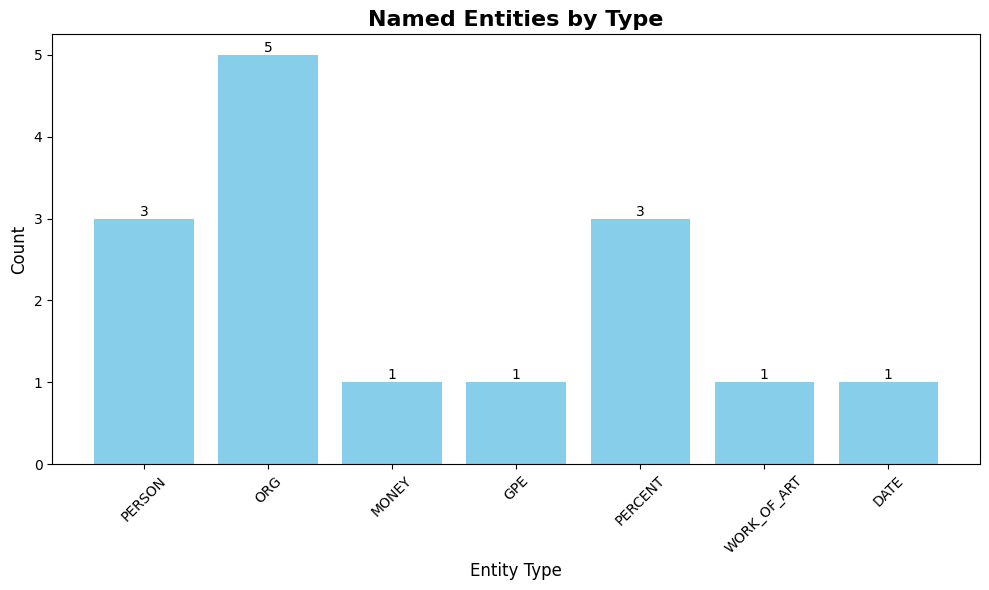

No keywords found


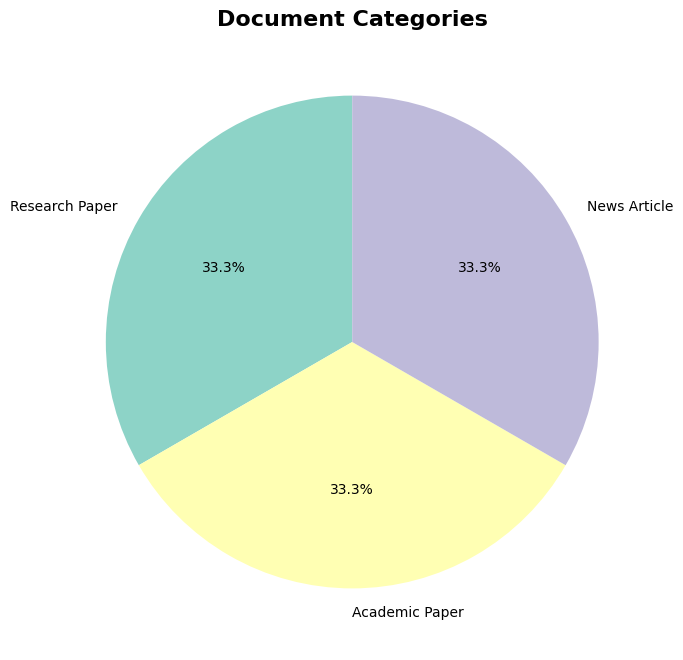

In [8]:
# Visualize the results
print("📊 Generating visualizations...")

# Entities visualization
visualize_entities(result['extracted_metadata']['entities'])

# Keywords visualization  
visualize_keywords(result['extracted_metadata']['keywords'])

# Categories visualization
visualize_categories(result['extracted_metadata']['categories'])


In [10]:
# Create multiple sample documents for batch processing
sample_docs = {
    'technical_report.txt': """
# Technical Report: Cloud Infrastructure Optimization

This technical report analyzes the performance optimization of cloud infrastructure 
for enterprise applications. The study was conducted by the DevOps team at Microsoft Azure.

## Executive Summary

Our analysis shows that implementing containerization and microservices architecture 
can improve system performance by 45% while reducing operational costs by 30%.

Key technologies: Docker, Kubernetes, AWS, Azure, Google Cloud Platform.
""",
    
    'financial_analysis.txt': """
# Quarterly Financial Analysis - Q4 2024

This financial report presents the quarterly performance analysis for TechCorp Inc. 
prepared by the Finance Department under CFO John Smith.

## Financial Highlights

- Revenue: $2.5 million (15% increase YoY)
- Net Profit: $450,000 (12% increase YoY)
- Operating Expenses: $1.8 million

The company shows strong growth in the technology sector with expanding market share.
"""
}

# Save sample documents
for filename, content in sample_docs.items():
    with open(filename, 'w') as f:
        f.write(content)

print("✅ Created sample documents for batch processing:")
for filename in sample_docs.keys():
    print(f"   📄 {filename}")


✅ Created sample documents for batch processing:
   📄 technical_report.txt
   📄 financial_analysis.txt


In [11]:
# Process all sample documents
print("🔄 Processing multiple documents...")
all_results = []
sample_files = ['sample_document.txt', 'technical_report.txt', 'financial_analysis.txt']

for filename in sample_files:
    if os.path.exists(filename):
        try:
            result = process_document(filename)
            all_results.append(result)
            print(f"✅ Processed {filename}")
        except Exception as e:
            print(f"❌ Failed to process {filename}: {e}")

print(f"\n🎉 Successfully processed {len(all_results)} documents!")


INFO:app.nlp.semantic_analysis:Extracted 15 entities


🔄 Processing multiple documents...
📄 Extracted 957 characters from sample_document.txt


INFO:app.nlp.semantic_analysis:Generated summary of 213 characters
INFO:app.nlp.semantic_analysis:Classified document into: ['Research Paper', 'Academic Paper', 'News Article']
ERROR:app.nlp.semantic_analysis:Keyword extraction failed: KeyBERT.extract_keywords() got an unexpected keyword argument 'top_k'. Did you mean 'top_n'?
INFO:app.nlp.semantic_analysis:Sentiment analysis: {'label': 'neutral', 'score': 0.8105899095535278}
INFO:app.metadata.dublin_core_mapper:Successfully mapped metadata to Dublin Core schema
INFO:app.nlp.semantic_analysis:Extracted 7 entities
Your max_length is set to 150, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


✅ Processed sample_document.txt
📄 Extracted 495 characters from technical_report.txt


INFO:app.nlp.semantic_analysis:Generated summary of 297 characters
INFO:app.nlp.semantic_analysis:Classified document into: ['Technical Documentation', 'News Article', 'Business Report']
ERROR:app.nlp.semantic_analysis:Keyword extraction failed: KeyBERT.extract_keywords() got an unexpected keyword argument 'top_k'. Did you mean 'top_n'?
INFO:app.nlp.semantic_analysis:Sentiment analysis: {'label': 'neutral', 'score': 0.7852301597595215}
INFO:app.metadata.dublin_core_mapper:Successfully mapped metadata to Dublin Core schema
INFO:app.nlp.semantic_analysis:Extracted 13 entities
Your max_length is set to 150, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


✅ Processed technical_report.txt
📄 Extracted 418 characters from financial_analysis.txt


INFO:app.nlp.semantic_analysis:Generated summary of 216 characters
INFO:app.nlp.semantic_analysis:Classified document into: ['Financial Report', 'Business Report', 'News Article']
ERROR:app.nlp.semantic_analysis:Keyword extraction failed: KeyBERT.extract_keywords() got an unexpected keyword argument 'top_k'. Did you mean 'top_n'?
INFO:app.nlp.semantic_analysis:Sentiment analysis: {'label': 'neutral', 'score': 0.885261595249176}
INFO:app.metadata.dublin_core_mapper:Successfully mapped metadata to Dublin Core schema


✅ Processed financial_analysis.txt

🎉 Successfully processed 3 documents!


In [14]:
# Create summary analysis
def create_metadata_summary(results):
    """Create a summary of multiple document results."""
    summary_data = []
    
    for result in results:
        metadata = result['extracted_metadata']
        summary_data.append({
            'filename': result['file_metadata'].get('filename', 'Unknown'),
            'text_length': metadata.get('text_length', 0),
            'word_count': metadata.get('word_count', 0),
            'entity_count': sum(len(v) for v in metadata.get('entities', {}).values()),
            'keyword_count': len(metadata.get('keywords', [])),
            'primary_category': metadata.get('categories', ['Unknown'])[0],
            'sentiment': metadata.get('sentiment', {}).get('label', 'Unknown')
        })
    
    return pd.DataFrame(summary_data)

# Generate summary
summary_df = create_metadata_summary(all_results)
print("📊 DOCUMENT PROCESSING SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))


📊 DOCUMENT PROCESSING SUMMARY
              filename  text_length  word_count  entity_count  keyword_count        primary_category sentiment
   sample_document.txt          957         127            15              0          Research Paper   neutral
  technical_report.txt          495          63             7              0 Technical Documentation   neutral
financial_analysis.txt          418          62            13              0        Financial Report   neutral


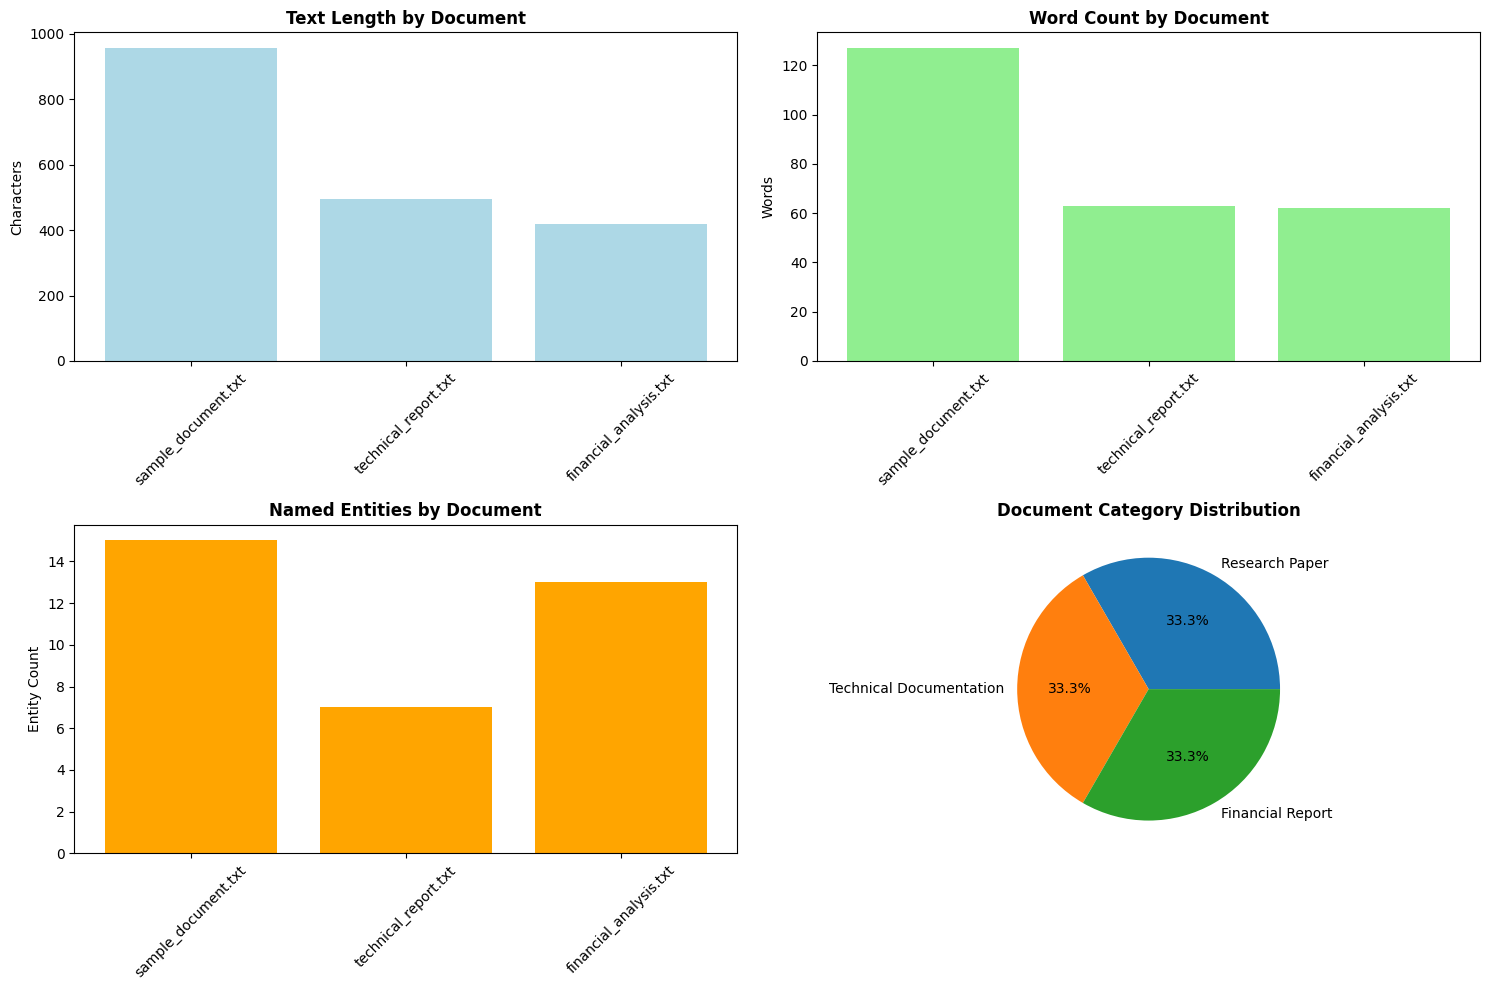

In [15]:
# Visualize summary statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Text length distribution
axes[0, 0].bar(summary_df['filename'], summary_df['text_length'], color='lightblue')
axes[0, 0].set_title('Text Length by Document', fontweight='bold')
axes[0, 0].set_ylabel('Characters')
axes[0, 0].tick_params(axis='x', rotation=45)

# Word count distribution
axes[0, 1].bar(summary_df['filename'], summary_df['word_count'], color='lightgreen')
axes[0, 1].set_title('Word Count by Document', fontweight='bold')
axes[0, 1].set_ylabel('Words')
axes[0, 1].tick_params(axis='x', rotation=45)

# Entity count distribution
axes[1, 0].bar(summary_df['filename'], summary_df['entity_count'], color='orange')
axes[1, 0].set_title('Named Entities by Document', fontweight='bold')
axes[1, 0].set_ylabel('Entity Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Document categories
category_counts = summary_df['primary_category'].value_counts()
axes[1, 1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
axes[1, 1].set_title('Document Category Distribution', fontweight='bold')

plt.tight_layout()
plt.show()


In [16]:
# Export all results to JSON
export_data = {
    'processing_summary': summary_df.to_dict('records'),
    'detailed_results': []
}

for result in all_results:
    export_data['detailed_results'].append({
        'filename': result['file_metadata'].get('filename'),
        'dublin_core_metadata': result['dublin_core_metadata'],
        'ai_analysis': {
            'entities': result['extracted_metadata']['entities'],
            'summary': result['extracted_metadata']['summary'],
            'categories': result['extracted_metadata']['categories'],
            'sentiment': result['extracted_metadata']['sentiment']
        }
    })

# Save to file
with open('metadata_generation_results.json', 'w') as f:
    json.dump(export_data, f, indent=2)

print("✅ Results exported to: metadata_generation_results.json")
print(f"📊 Total documents processed: {len(all_results)}")
print("🎉 Demo completed successfully!")


✅ Results exported to: metadata_generation_results.json
📊 Total documents processed: 3
🎉 Demo completed successfully!
